<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Accessing CarbonPlan CMIP6 downscaled climate datasets

Authors: Oriana Chegwidden and Max Jones

This notebook offers users examples of accessing and working with CarbonPlan's downscaled climate datasets. The dataset collection is further described in an article located here: <TK>. Monthly and annual summaries of the data products are visible in an interactive mappting tool located here: <TK>. The underlying daily data will be best worked with in a computing environment. Below we show examples of reading the data, performing basic analysis, and downloading subsets in space and time. We welcome further requests for interaction and encourage feedback via GitHub!

In [80]:
%load_ext autoreload
%autoreload 2
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import cartopy.crs as ccrs
from carbonplan import styles
import intake

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from cmip6_downscaling.analysis.analysis import (
    qaqc_checks,
    grab_big_city_data,
    load_big_cities,
    get_seasonal,
    change_ds,
)
from cmip6_downscaling.analysis.plot import plot_city_data
from cmip6_downscaling.analysis.analysis import change_ds

xr.set_options(keep_attrs=True)

Let's load in the catalog of datasets available in this release.

In [124]:
cat = intake.open_esm_datastore(
    'https://cmip6downscaling.blob.core.windows.net/version1/catalogs/global-downscaled-CMIP6.json'
)

We can inspect the contents according to different methods.

In [126]:
cat_subset = cat.search(method="GARD-SV")
cat_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,timescale,variable_id,method,downscaled_daily_data_uri,version
0,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,day,tasmax,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
1,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,day,tasmin,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
2,CMIP,CCCma,CanESM5,historical,r1i1p1f1,day,pr,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
3,CMIP,CCCma,CanESM5,historical,r1i1p1f1,day,tasmax,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
4,CMIP,CCCma,CanESM5,historical,r1i1p1f1,day,tasmin,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
5,CMIP,MIROC,MIROC6,historical,r1i1p1f1,day,pr,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
6,CMIP,MIROC,MIROC6,historical,r1i1p1f1,day,tasmax,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
7,CMIP,MIROC,MIROC6,historical,r1i1p1f1,day,tasmin,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
8,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,day,pr,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
9,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,day,tasmax,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1


Now let's specify what models we're interested in.

In [117]:
cat_subset = cat.search(
    method="GARD-MV", source_id="MRI-ESM2-0", experiment_id="ssp245", variable_id="tasmax"
)

In [118]:
dsets = cat_subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.timescale.method'


In [119]:
dsets

{'ScenarioMIP.MRI.MRI-ESM2-0.ssp245.day.GARD-MV': <xarray.Dataset>
 Dimensions:    (lat: 721, lon: 1440, member_id: 1, time: 31046)
 Coordinates:
   * lat        (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
   * lon        (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
   * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2099-12-31
   * member_id  (member_id) <U8 'r1i1p1f1'
 Data variables:
     tasmax     (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 31046, 48, 48), meta=np.ndarray>
 Attributes:
     history:                 Created: Tue Jun 28 06:08:02 2022
     hostname:                jupyter-norlandrhagen--prod-5f2-5fhuge
     institution:             CarbonPlan
     source:                  /srv/conda/envs/notebook/bin/prefect
     title:                   gard_fit_and_predict
     username:                norlandrhagen
     version:                 0.1.9.post23
     intake_esm_varname:      ['tasmax']
     intake_es

And now let's load that dataset into the notebook.

In [121]:
ds = dsets['ScenarioMIP.MRI.MRI-ESM2-0.ssp245.day.GARD-MV']

Let's switch to Celcius to make it easer to interpret

In [122]:
ds -= 273.15

We'll mask out the ocean values and load data for the a single timestep and a region of interest. We'll start with the East Africa region we reference in the companion web article.

In [123]:
east_africa_region = {'lat': slice(-3, 17), 'lon': slice(17, 57)}
# load a timestep for a smaller region. we'll start with
east_africa_tasmax = ds.tasmax.sel(time="2022-08-01").sel(**east_africa_region).load()
# load a land mask
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
# load a projection
projection = ccrs.PlateCarree()
# make a land mask appropriate for our data
east_africa_land_mask = land.mask(east_africa_tasmax)
# mask our data with that land mask
east_africa_tasmax = east_africa_tasmax.where(east_africa_land_mask == 0).load()

And now let's plot that single timeslice

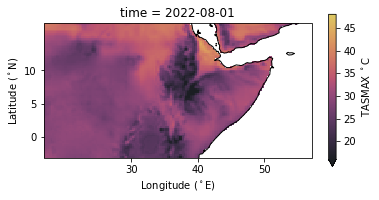

In [45]:
fig, ax = plt.subplots(subplot_kw=dict(projection=projection))
tasmax.plot(
    cbar_kwargs=dict(shrink=0.7, label="TASMAX $^\circ$C"), cmap='warm_dark', vmin=16, vmax=48
)
ax.coastlines()
ax.set_xticks([30, 40, 50], crs=projection)
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_yticks([0, 5, 10], crs=projection)
ax.set_ylabel('Latitude ($^\circ$N)')
plt.show()

Now let's do the same thing but for the whole globe. And while we're at it, let's grab the annual mean temperatures of that daily data for a 30 year period at the end of the century (the "2080s"). Caution - this could take a while (i.e., minutes)- it's a lot of data! We'll define two timeslices (we'll use the second one later in the notebook).

In [116]:
time_slices = {'2030s': slice('2020', '2049'), '2080s': slice('2070', '2099')}

In [46]:
# load a timestep for a smaller region. we'll start with
tasmax_2080s = ds.tasmax.sel(time=time_slices['2080s']).mean(dim='time').load()
# load a land mask
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
# load a projection
projection = ccrs.PlateCarree()
# make a land mask appropriate for our data
global_land_mask = land.mask(tasmax_2080s)
# mask our data with that land mask
tasmax_2080s = tasmax_2080s.where(global_land_mask == 0).load()

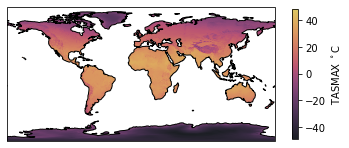

In [49]:
fig, ax = plt.subplots(subplot_kw=dict(projection=projection))
tasmax_2080s.plot(cbar_kwargs=dict(shrink=0.6, label="TASMAX $^\circ$C"), cmap='warm_dark')
ax.coastlines()

Let's look at the data at some individual points! After all, one of the main goals of downscaling is to provide more local information. We'll grab timeseries from 100 big cities around the world to explore what climate change might look like for them.

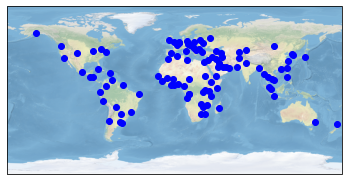

In [50]:
big_cities = load_big_cities(num_cities=100, add_additional_cities=True, plot=True)

In [69]:
[downscaled_cities] = grab_big_city_data([ds], big_cities)

Let's plot a timeseries of the daily data at just one of those 100 cities. We'll go with Seattle since I'm biased and am from there.

Text(0, 0.5, 'Average daily maximum temperature $^\\circ$C')

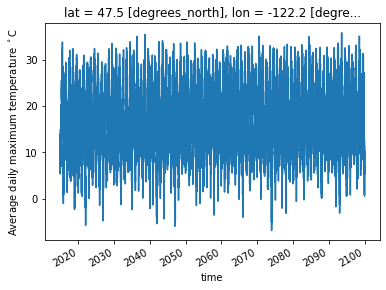

In [53]:
ts = downscaled_cities.sel(cities='Seattle').tasmax
ts.plot()
plt.ylabel("Average daily maximum temperature $^\circ$C")

That's a lot of daily data though- we can make it clearer by summarizing it into a seasonal cycle. Let's comparing 30 year periods near the start and end of the 21st century to see this model's projection of changes in temperature at this location.

Text(0.5, 0, '')

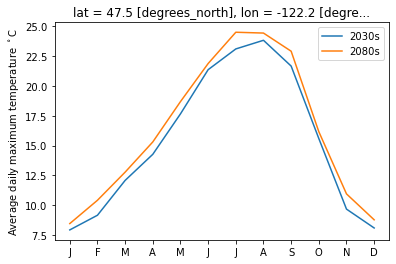

In [54]:
fig, ax = plt.subplots()
for label, time_slice in time_slices.items():
    ts.sel(time=time_slice).groupby('time.month').mean().plot(label=label)
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.legend()
plt.ylabel("Average daily maximum temperature $^\circ$C")
plt.xlabel('')

Now let's do that for all of the cities we grabbed to get a sense of how popualtion centers around the world will fare.

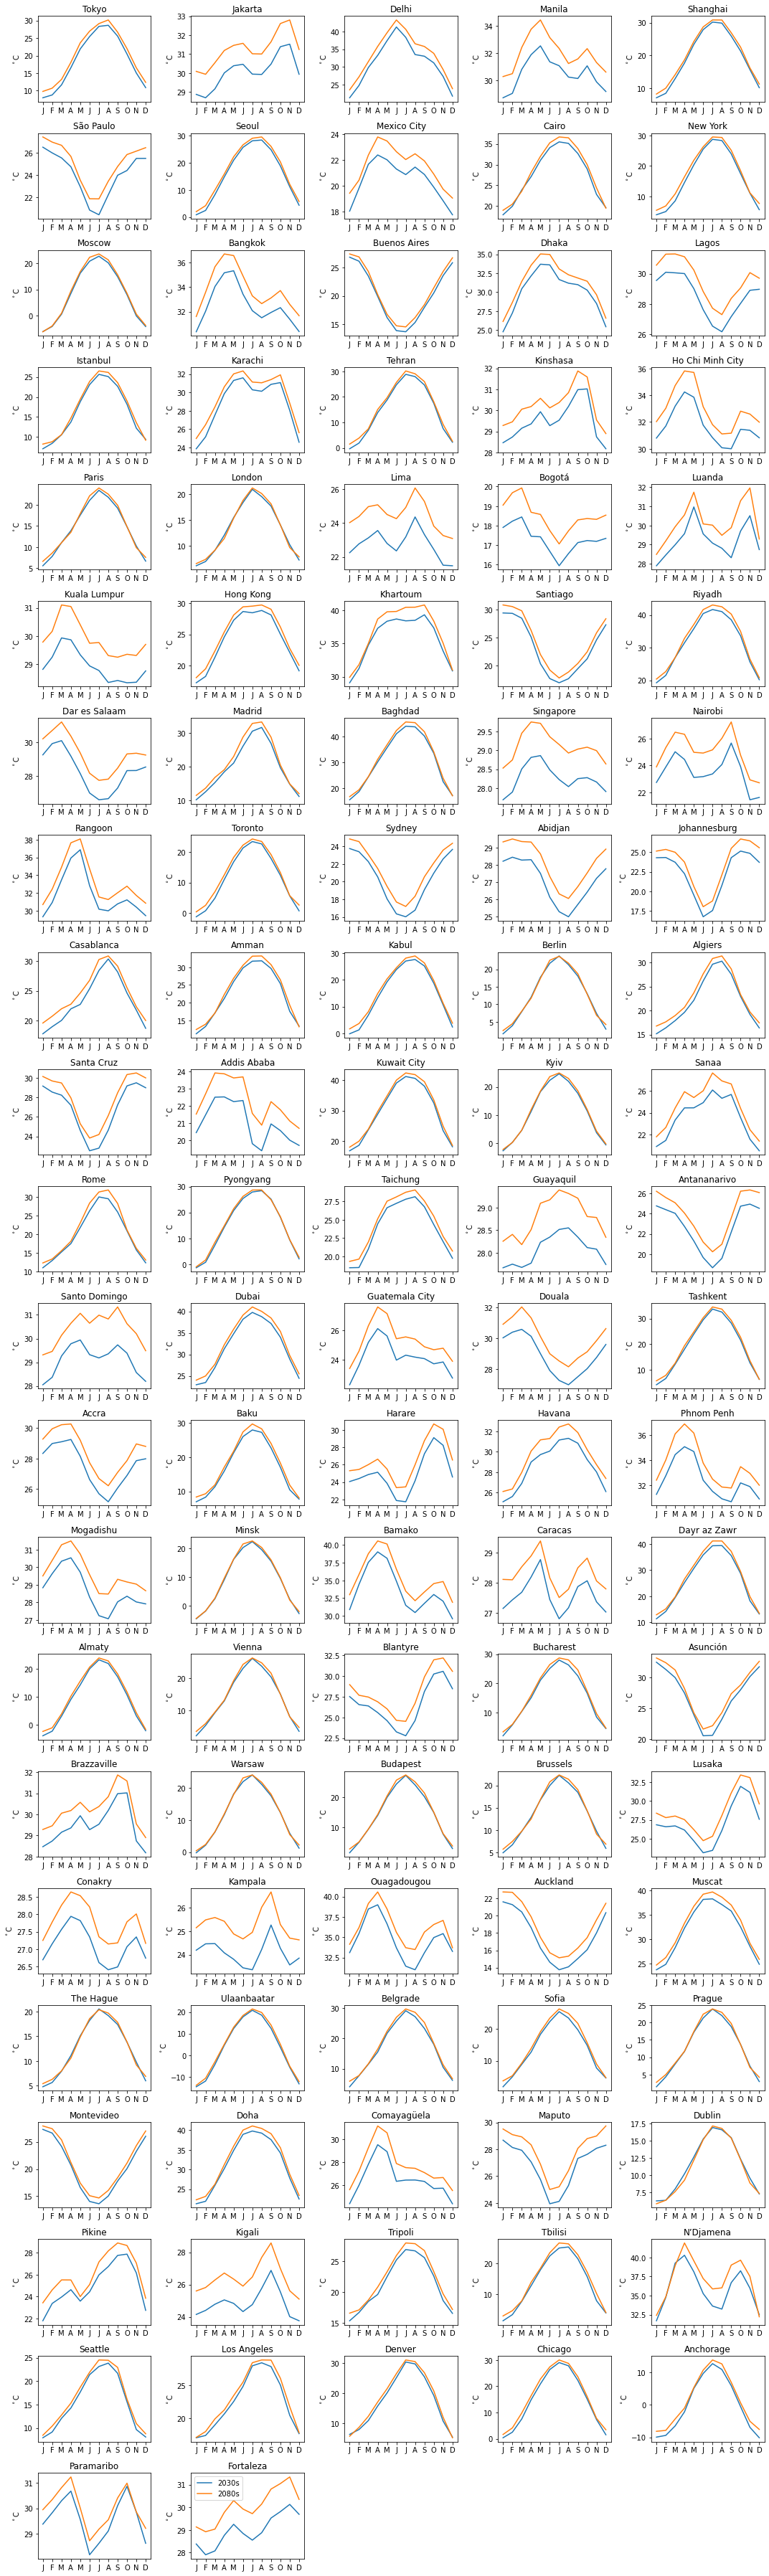

In [73]:
plot_city_data(
    downscaled_cities.tasmax,
    time_slices=time_slices,
    aggregation='seasonal_cycle',
    ylabel="$^\circ$C",
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


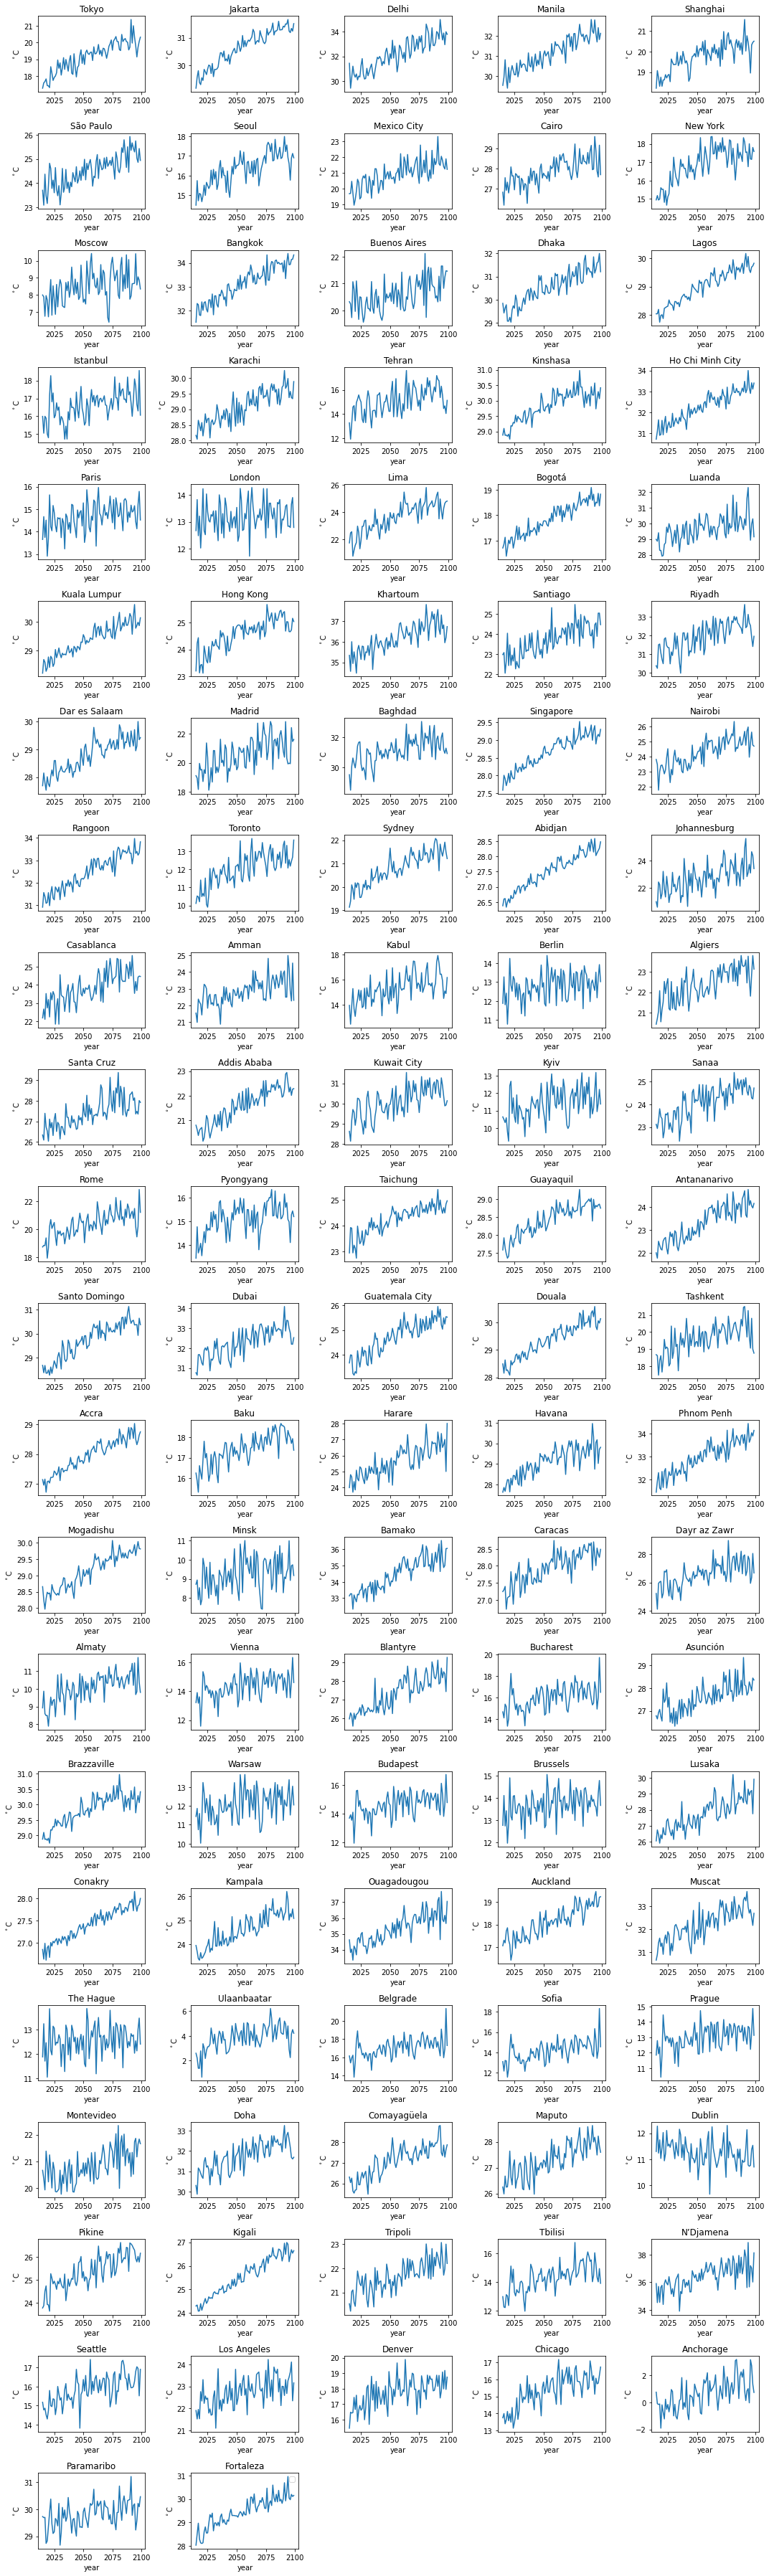

In [72]:
plot_city_data(downscaled_cities.tasmax, aggregation='annual', ylabel="$^\circ$C")

Let's plot a global map now. FYI, it will take a few minutes - after all, we're working with large datasets!

And now let's download one of these daily timeseries to work with on our own computer.

In [75]:
ts.to_dataframe().to_csv('seattle.csv')

We can also download a small regional subset as a netcdf file locally. Note that this might be quite large. We'll first check out how big it is.

In [77]:
print('Dataset is {} GB'.format(ds.sel(**east_africa_region).nbytes * 1e-9))

Dataset is 1.6197328800000002 GB


If you want to save it locally switch the flag to `True`.

In [ ]:
save_subset = False
if save_subset:
    ds.sel(**east_africa_region).to_netcdf('region.nc')